# GAN

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchsummary import summary
from torchvision.utils import make_grid
from torchvision.models import inception_v3
from scipy.linalg import sqrtm

import warnings
warnings.filterwarnings('ignore')

### Initialize functions

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
os.makedirs('images', exist_ok=True)
def save_generated_images(epoch, generator, fixed_noise):
    with torch.no_grad():
        generator.eval()
        # Generate images
        generated_images = generator(fixed_noise).detach().cpu()
        grid = make_grid(generated_images, nrow=10, normalize=True)
        plt.figure(figsize=(10,10))
        plt.imshow(np.transpose(grid, (1,2,0)))
        plt.axis('off')
        plt.title(f"Epoch {epoch+1}")
        plt.savefig(f"images/epoch_{epoch+1}.png")
        plt.show()
        generator.train()

In [4]:
def plot_loss(G_losses, D_losses):
    plt.plot(G_losses, label='Generator')
    plt.plot(D_losses, label='Discriminator')
    plt.title("Losses Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(f'loss_plot.png')

In [5]:
def calculate_fid(generator, z_dim=64, batch_size=128, device='cpu'):
    transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.CenterCrop(299),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


    inception_model = inception_v3(pretrained=True).to(device)
    inception_model.eval()
    inception_model.fc = torch.nn.Identity()

    ## Fréchet Inception Distance
    def matrix_sqrt(x):
        y = x.cpu().detach().numpy()
        y = scipy.linalg.sqrtm(y)
        return torch.Tensor(y.real, device=x.device)

    def frechet_distance(mu_x, mu_y, sigma_x, sigma_y):
        return (mu_x - mu_y).dot(mu_x - mu_y) + torch.trace(sigma_x) + torch.trace(sigma_y) - 2*torch.trace(matrix_sqrt(sigma_x @ sigma_y))

    def preprocess(img):
        img = torch.nn.functional.interpolate(img, size=(299, 299), mode='bilinear', align_corners=False)
        img = img.repeat(1, 3, 1, 1)
        return img

    def get_covariance(features):
        return torch.Tensor(np.cov(features.detach().numpy(), rowvar=False))

    fake_features_list = []
    real_features_list = []

    generator.eval()
    n_samples = 512

    cur_samples = 0
    with torch.no_grad():
        for real_example, _ in tqdm(dataloader, total=n_samples // 4):
            real_samples = real_example
            real_features = inception_model(real_samples.to(device)).detach().to('cpu')
            real_features_list.append(real_features)

            z = torch.randn((len(real_example),z_dim), device=device)
            img = torch.nn.functional.interpolate(generator(z), size=(299, 299), mode='bilinear', align_corners=False)
            img = img.repeat(1, 3, 1, 1)

            fake_samples = preprocess(generator(z))

            fake_features = inception_model(fake_samples.to(device)).detach().to('cpu')
            fake_features_list.append(fake_features)
            cur_samples += len(real_samples)
            if cur_samples >= n_samples:
                break

    fake_features_all = torch.cat(fake_features_list)
    real_features_all = torch.cat(real_features_list)

    mu_fake = fake_features_all.mean(0)
    mu_real = real_features_all.mean(0)
    sigma_fake = get_covariance(fake_features_all)
    sigma_real = get_covariance(real_features_all)

    with torch.no_grad():
        return (mu_real - mu_fake).dot(mu_real - mu_fake) + torch.trace(sigma_real) + torch.trace(sigma_fake) - 2*torch.trace(matrix_sqrt(sigma_real @ sigma_fake))

### Load Data

In [6]:
batch_size = 128

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 121198912.20it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 91908720.66it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 78924205.97it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1558325.46it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Q2.1: GAN model

### Build Model

In [7]:
class Generator(nn.Module):
    def __init__(self, input_dim=64):
        super(Generator, self).__init__()
        self.part_1_2 = nn.Sequential(
            nn.Linear(in_features=input_dim, out_features=512),
            nn.BatchNorm1d(num_features=512),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=512, out_features=16*14*14),
            nn.BatchNorm1d(num_features=16*14*14),
            nn.ReLU(inplace=True),
        )
        self.part_3_4_5_6 = nn.Sequential(
            nn.PixelShuffle(upscale_factor=14),  # 16 channels, 14x14 image
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),  # 32 channels, 14x14 image
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.PixelShuffle(upscale_factor=2),  # 8 channels, 28x28 image
            nn.Conv2d(in_channels=8, out_channels=1, kernel_size=3, padding=1),  # 1 channel, 28x28 image
        )

    def forward(self, z):
        img = self.part_1_2(z)
        img = self.part_3_4_5_6(img.view(img.size(0), -1, 1, 1))
        return img

In [ ]:
sample_model = Generator().to(device)
summary(sample_model, (64,),batch_size=64)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [64, 512]          33,280
       BatchNorm1d-2                  [64, 512]           1,024
              ReLU-3                  [64, 512]               0
            Linear-4                 [64, 3136]       1,608,768
       BatchNorm1d-5                 [64, 3136]           6,272
              ReLU-6                 [64, 3136]               0
      PixelShuffle-7           [64, 16, 14, 14]               0
            Conv2d-8           [64, 32, 14, 14]           4,640
       BatchNorm2d-9           [64, 32, 14, 14]              64
             ReLU-10           [64, 32, 14, 14]               0
     PixelShuffle-11            [64, 8, 28, 28]               0
           Conv2d-12            [64, 1, 28, 28]              73
Total params: 1,654,121
Trainable params: 1,654,121
Non-trainable params: 0
---------------------------

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=64*7*7, out_features=512),  # Flatten 64x7x7 feature maps
            nn.ReLU(inplace=True),
            nn.Linear(in_features=512, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.feature(x)
        x = self.classifier(x)
        return x

In [ ]:
sample_model = Discriminator().to(device)
summary(sample_model, (1,28,28),batch_size=64)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [64, 32, 14, 14]             544
              ReLU-2           [64, 32, 14, 14]               0
            Conv2d-3             [64, 64, 7, 7]          32,832
              ReLU-4             [64, 64, 7, 7]               0
           Flatten-5                 [64, 3136]               0
            Linear-6                  [64, 512]       1,606,144
              ReLU-7                  [64, 512]               0
            Linear-8                    [64, 1]             513
           Sigmoid-9                    [64, 1]               0
Total params: 1,640,033
Trainable params: 1,640,033
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 11.22
Params size (MB): 6.26
Estimated Total Size (MB): 17.67
-------------------------------------

### Loss Functions

In [8]:
epsilon = 1e-8

def discriminator_loss(real_output, fake_output):
    real_loss = torch.mean(torch.log(real_output + epsilon))
    fake_loss = torch.mean(torch.log(1 - fake_output + epsilon))
    return -(real_loss + fake_loss)

def generator_loss(fake_output):
    return -torch.mean(torch.log(fake_output + epsilon))


### Initialize models

In [ ]:
input_dim = 64
generator = Generator(input_dim).to(device)
discriminator = Discriminator().to(device)

# Optimizers
learning_rate = 0.0002
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate)

### Training Loop

In [ ]:
num_epochs = 100

G_losses = []
D_losses = []
gen_imgs_list = []

for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(train_loader):
        real_imgs = imgs.to(device)

        z = torch.randn((imgs.size(0),input_dim), device=device)
        gen_imgs = generator(z)

        # Train Generator
        optimizer_g.zero_grad()
        d_g_z = discriminator(gen_imgs)
        g_loss = generator_loss(d_g_z)
        # print(f'\r[{i}] g_loss: {g_loss:0.2f}, D(G(z))={d_g_z[0].tolist()[0]:0.2f}',end=' - ')
        g_loss.backward()
        optimizer_g.step()

        # Train Discriminator
        optimizer_d.zero_grad()
        d_x = discriminator(real_imgs)
        d_g_z = discriminator(gen_imgs.detach())
        d_loss = discriminator_loss(d_x, d_g_z)
        # print(f'd_loss: {d_loss:0.2f}, D(G(z))={d_g_z[0].tolist()[0]:0.2f}, D(x)={d_x[0].tolist()[0]:0.2f}',end='')
        d_loss.backward()
        optimizer_d.step()

    G_losses.append(g_loss.item())
    D_losses.append(d_loss.item())
    if epoch%10==0:
        gen_imgs_list.append(gen_imgs.detach()) # TODO
    print(f"[Epoch {epoch+1}/{num_epochs}] => [D loss: {d_loss}] [G loss: {g_loss}]")
    # Generate and save images at the start, mid, and end of training
    if (epoch+1) % 10 == 0:
        save_generated_images(epoch, generator, z)

[Epoch 1/100] => [D loss: 0.14476986229419708] [G loss: 3.1865878105163574]
[Epoch 2/100] => [D loss: 0.25684869289398193] [G loss: 2.44968318939209]
[Epoch 3/100] => [D loss: 0.30455178022384644] [G loss: 2.2559289932250977]
[Epoch 4/100] => [D loss: 0.32572802901268005] [G loss: 3.2730631828308105]
[Epoch 5/100] => [D loss: 0.3394227921962738] [G loss: 1.9689855575561523]
[Epoch 6/100] => [D loss: 0.6842950582504272] [G loss: 3.364893913269043]
[Epoch 7/100] => [D loss: 0.2730644941329956] [G loss: 2.7888190746307373]
[Epoch 8/100] => [D loss: 0.15901018679141998] [G loss: 3.202082633972168]
[Epoch 9/100] => [D loss: 0.29751789569854736] [G loss: 2.1580710411071777]
[Epoch 10/100] => [D loss: 0.33326736092567444] [G loss: 3.967205047607422]
[Epoch 11/100] => [D loss: 0.15684325993061066] [G loss: 4.664890289306641]
[Epoch 12/100] => [D loss: 0.3411935567855835] [G loss: 2.8493027687072754]
[Epoch 13/100] => [D loss: 0.2713173031806946] [G loss: 3.8794848918914795]
[Epoch 14/100] => [

### Plot loss function

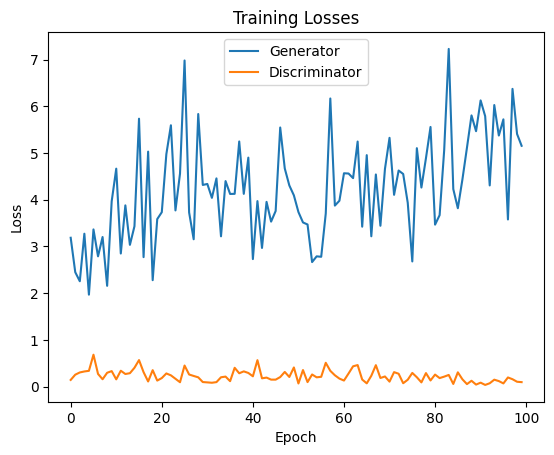

In [ ]:
plot_loss(G_losses, D_losses)

### Generate sample number in first, mid, and last epochs

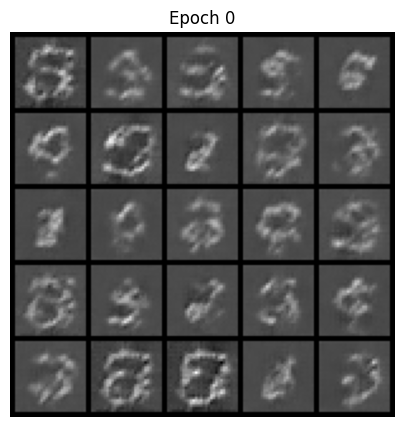

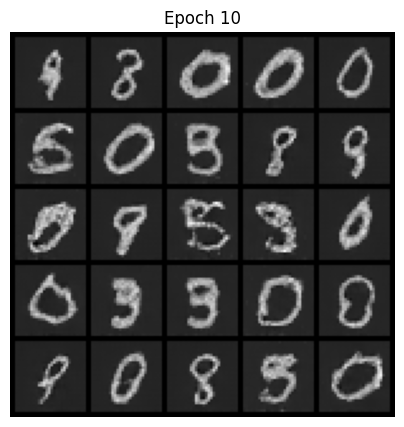

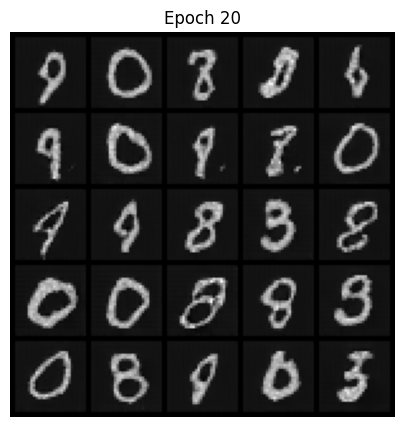

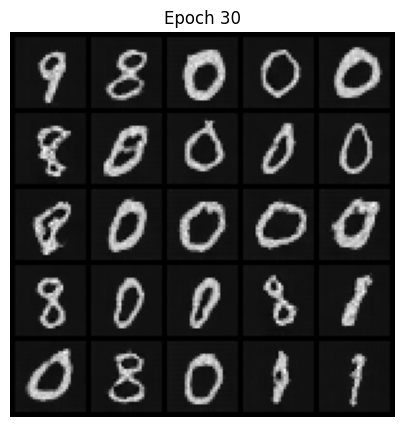

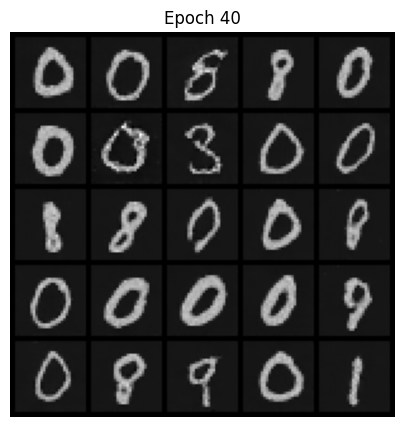

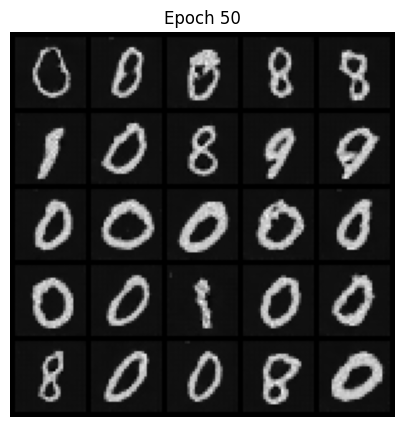

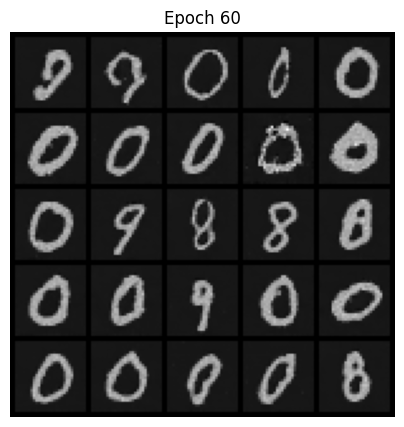

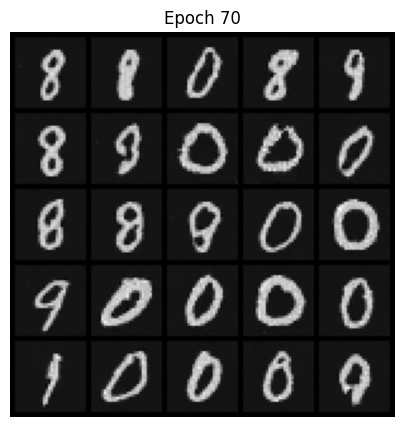

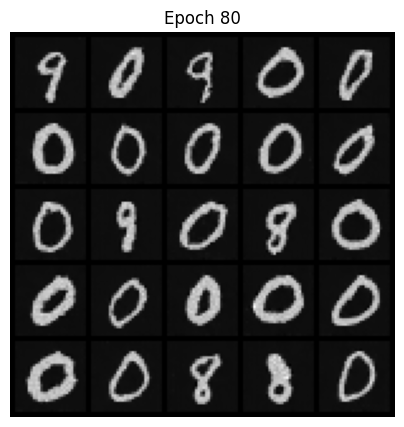

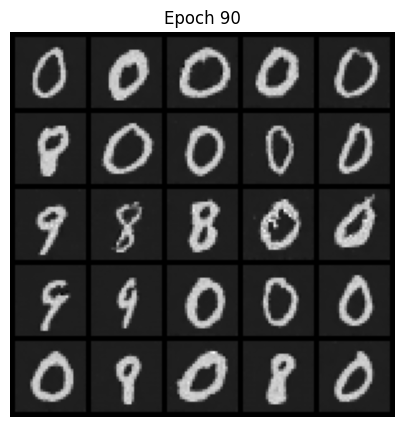

In [ ]:
for i, gen_imgs in enumerate(gen_imgs_list):
    gen_imgs = gen_imgs[:25,:,:,:].detach().cpu()*0.5+0.5
    grid = make_grid(gen_imgs, nrow=5, normalize=True)

    plt.figure(figsize=(5, 5))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.title(f"Epoch {10*i}")
    plt.savefig(f"./GAN samples/epoch_{10*i}.png")
    plt.show()

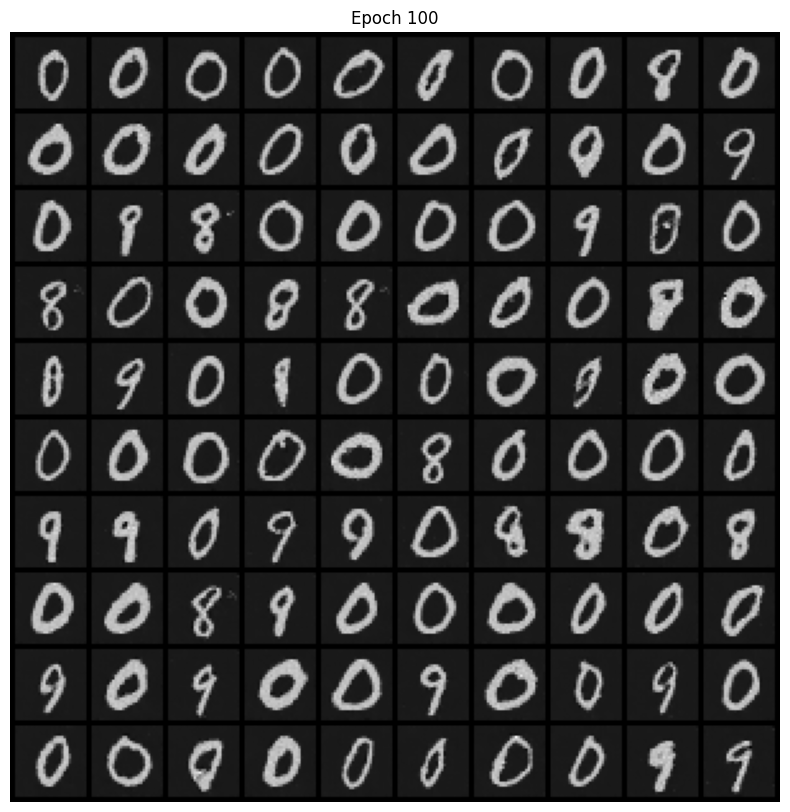

In [ ]:
save_generated_images(100, generator, torch.randn((100,64), device=device))

### Calculate FID score

In [ ]:
fid_value = calculate_fid(generator, batch_size=batch_size, device=device)
print(f'\nFID score: {fid_value}')

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 107MB/s]
  2%|▏         | 3/128 [07:45<5:23:16, 155.17s/it]


FID score: 74.434326171875


### Save/Load model

* Save the model

In [ ]:
# Save the Generator
torch.save(generator.state_dict(), './generator_state.pth')

# Save the Discriminator
torch.save(discriminator.state_dict(), './discriminator_state.pth')

* Load the model

In [ ]:
generator = Generator()
discriminator = Discriminator()

generator.load_state_dict(torch.load('generator_state.pth', map_location=torch.device(device)))
discriminator.load_state_dict(torch.load('discriminator_state.pth', map_location=torch.device(device)))

Generator(
  (part_1_2): Sequential(
    (0): Linear(in_features=64, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=512, out_features=3136, bias=True)
    (4): BatchNorm1d(3136, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (part_3_4_5_6): Sequential(
    (0): PixelShuffle(upscale_factor=14)
    (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): PixelShuffle(upscale_factor=2)
    (5): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

## Q2.2: Wasserstein GAN

In [9]:
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=64*7*7, out_features=512),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=512, out_features=1),
            # Delete sigmoid layer
        )

    def forward(self, x):
        x = self.feature(x)
        x = self.classifier(x)
        return x

In [ ]:
# del generator
# del critic
# torch.cuda.empty_cache()

In [10]:
# Initialize Generator and Critic
generator = Generator().to(device)
critic = Critic().to(device)

# Optimizers
optimizer_G = optim.RMSprop(generator.parameters(), lr=0.0001)
optimizer_C = optim.RMSprop(critic.parameters(), lr=0.0001)

### Define loss functions

In [11]:
def critic_loss(critic, real_images, fake_images):
    real_scores = critic(real_images)
    fake_scores = critic(fake_images)
    return fake_scores.mean() - real_scores.mean()

def generator_loss(critic, fake_images):
    return -critic(fake_images).mean()

def gradient_penalty(critic, real_images, fake_images, device, lambda_gp=10):
    # Calculate the interpolation
    alpha = torch.rand(real_images.size(0), 1, 1, 1, device=device)
    interpolated_images = alpha * real_images.data + (1 - alpha) * fake_images.data
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    interpolated_scores = critic(interpolated_images)

    # Get gradients of scores with respect to inputs
    gradients = torch.autograd.grad(outputs=interpolated_scores, inputs=interpolated_images,
                                    grad_outputs=torch.ones(interpolated_scores.size()).to(device),
                                    create_graph=True, retain_graph=True)[0]

    # Flatten the gradients to calculate the norm
    gradients = gradients.view(gradients.size(0), -1)

    # Calculate the gradient penalty as per the paper
    gradient_norm = gradients.norm(2, dim=1)
    gradient_penalty = lambda_gp * ((gradient_norm - 1) ** 2).mean()
    return gradient_penalty

### Training loop

[Epoch 1/100] [Critic loss: -4.334157466888428] [Generator loss: 4.675953388214111]


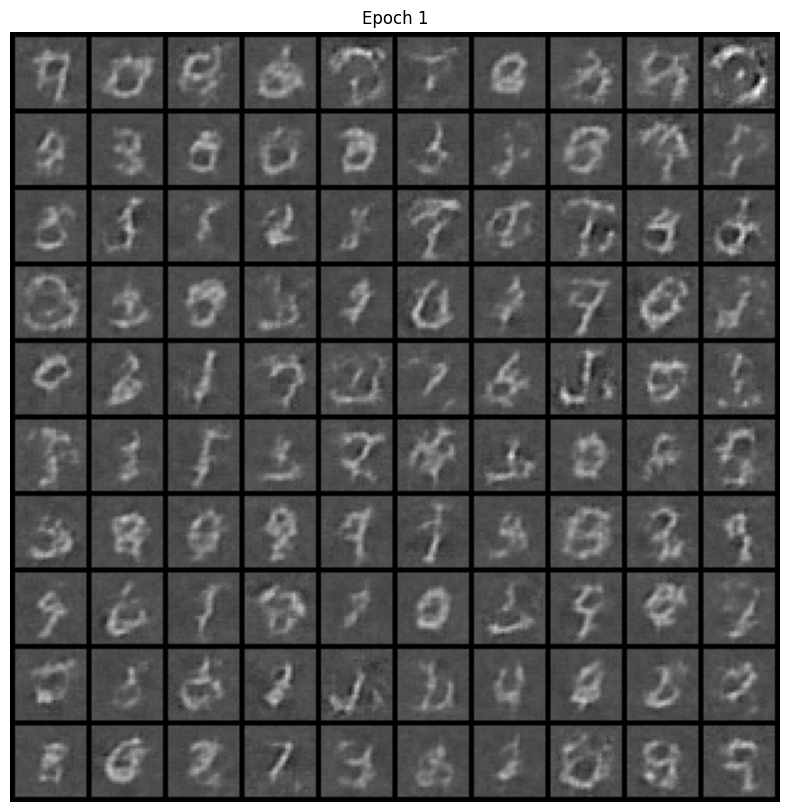

[Epoch 2/100] [Critic loss: -3.768928289413452] [Generator loss: 5.188981056213379]
[Epoch 3/100] [Critic loss: -3.316772937774658] [Generator loss: 5.135886192321777]
[Epoch 4/100] [Critic loss: -3.08137583732605] [Generator loss: 3.407032012939453]
[Epoch 5/100] [Critic loss: -2.755640983581543] [Generator loss: 4.776270866394043]
[Epoch 6/100] [Critic loss: -2.8391664028167725] [Generator loss: 5.39090633392334]
[Epoch 7/100] [Critic loss: -2.4157724380493164] [Generator loss: 5.081864356994629]
[Epoch 8/100] [Critic loss: -2.5777337551116943] [Generator loss: 7.387881278991699]
[Epoch 9/100] [Critic loss: -2.4019551277160645] [Generator loss: 7.614823341369629]
[Epoch 10/100] [Critic loss: -2.364638090133667] [Generator loss: 8.04526424407959]


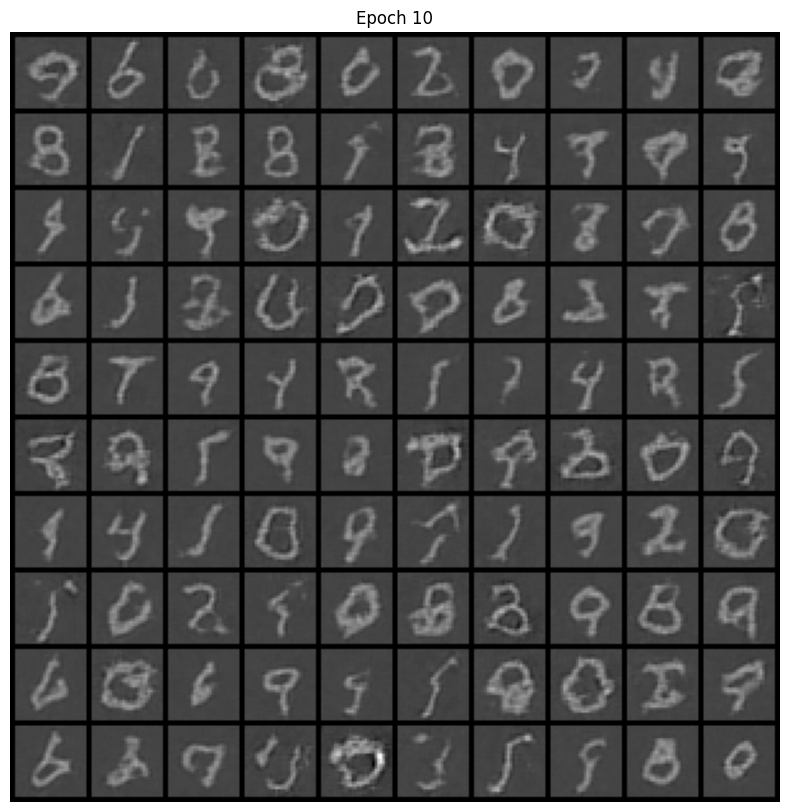

[Epoch 11/100] [Critic loss: -2.3382647037506104] [Generator loss: 5.7435455322265625]
[Epoch 12/100] [Critic loss: -2.158029794692993] [Generator loss: 5.864387512207031]
[Epoch 13/100] [Critic loss: -1.961389183998108] [Generator loss: 6.845564842224121]
[Epoch 14/100] [Critic loss: -2.1610095500946045] [Generator loss: 8.332948684692383]
[Epoch 15/100] [Critic loss: -2.211422920227051] [Generator loss: 9.069267272949219]
[Epoch 16/100] [Critic loss: -2.067962884902954] [Generator loss: 6.955986022949219]
[Epoch 17/100] [Critic loss: -2.0530126094818115] [Generator loss: 9.110983848571777]
[Epoch 18/100] [Critic loss: -1.811990737915039] [Generator loss: 5.139197826385498]
[Epoch 19/100] [Critic loss: -1.782336950302124] [Generator loss: 6.7315473556518555]
[Epoch 20/100] [Critic loss: -2.0134079456329346] [Generator loss: 8.747288703918457]


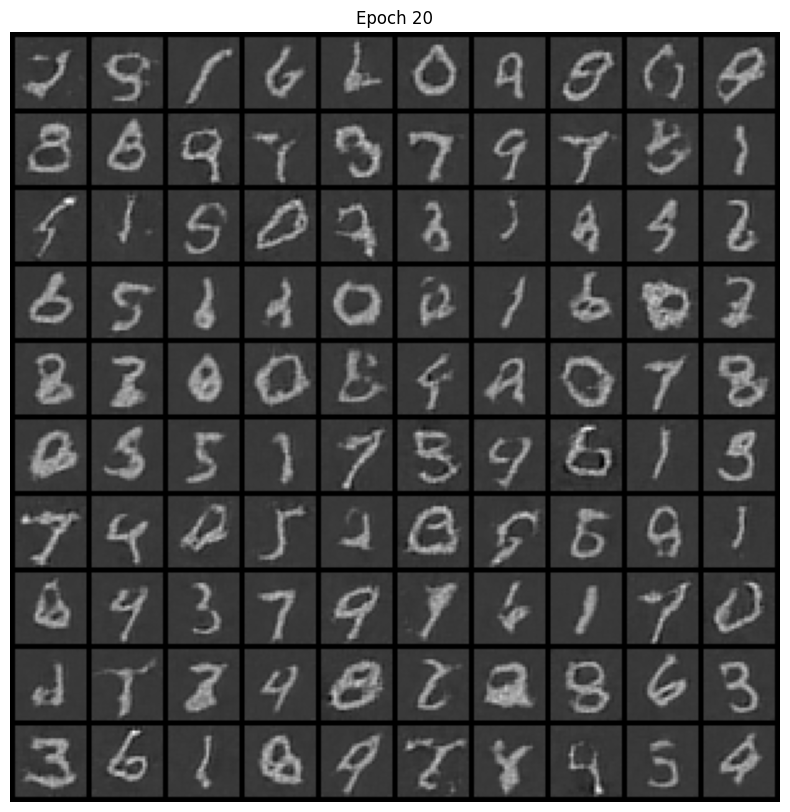

[Epoch 21/100] [Critic loss: -1.7905319929122925] [Generator loss: 3.8754451274871826]
[Epoch 22/100] [Critic loss: -1.8740618228912354] [Generator loss: 8.060256958007812]
[Epoch 23/100] [Critic loss: -1.6671843528747559] [Generator loss: 8.158828735351562]
[Epoch 24/100] [Critic loss: -1.5610334873199463] [Generator loss: 7.927144527435303]
[Epoch 25/100] [Critic loss: -1.5401785373687744] [Generator loss: 8.468204498291016]
[Epoch 26/100] [Critic loss: -1.4907556772232056] [Generator loss: 9.022067070007324]
[Epoch 27/100] [Critic loss: -1.551660418510437] [Generator loss: 8.094734191894531]
[Epoch 28/100] [Critic loss: -1.5753734111785889] [Generator loss: 8.134735107421875]
[Epoch 29/100] [Critic loss: -1.577594518661499] [Generator loss: 9.691442489624023]
[Epoch 30/100] [Critic loss: -1.3692063093185425] [Generator loss: 9.436403274536133]


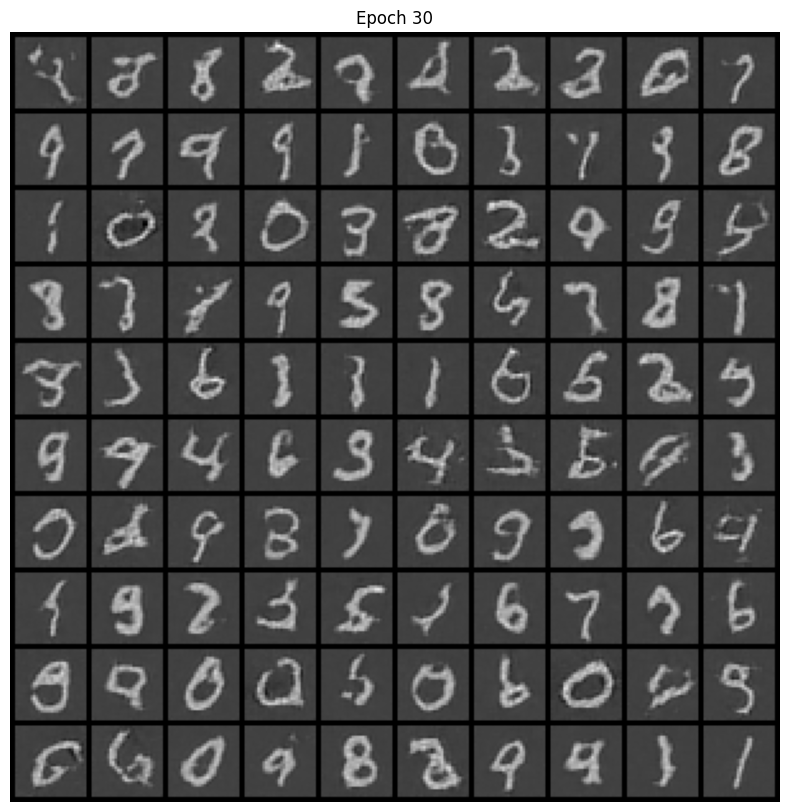

[Epoch 31/100] [Critic loss: -1.474744200706482] [Generator loss: 10.357775688171387]
[Epoch 32/100] [Critic loss: -1.5321820974349976] [Generator loss: 9.821375846862793]
[Epoch 33/100] [Critic loss: -1.6691898107528687] [Generator loss: 9.741839408874512]
[Epoch 34/100] [Critic loss: -1.4049274921417236] [Generator loss: 9.642614364624023]
[Epoch 35/100] [Critic loss: -1.3891557455062866] [Generator loss: 8.245243072509766]
[Epoch 36/100] [Critic loss: -1.4869877099990845] [Generator loss: 8.403095245361328]
[Epoch 37/100] [Critic loss: -1.4798249006271362] [Generator loss: 9.781633377075195]
[Epoch 38/100] [Critic loss: -1.2991371154785156] [Generator loss: 10.765958786010742]
[Epoch 39/100] [Critic loss: -1.4710309505462646] [Generator loss: 10.438334465026855]
[Epoch 40/100] [Critic loss: -1.378756046295166] [Generator loss: 11.149828910827637]


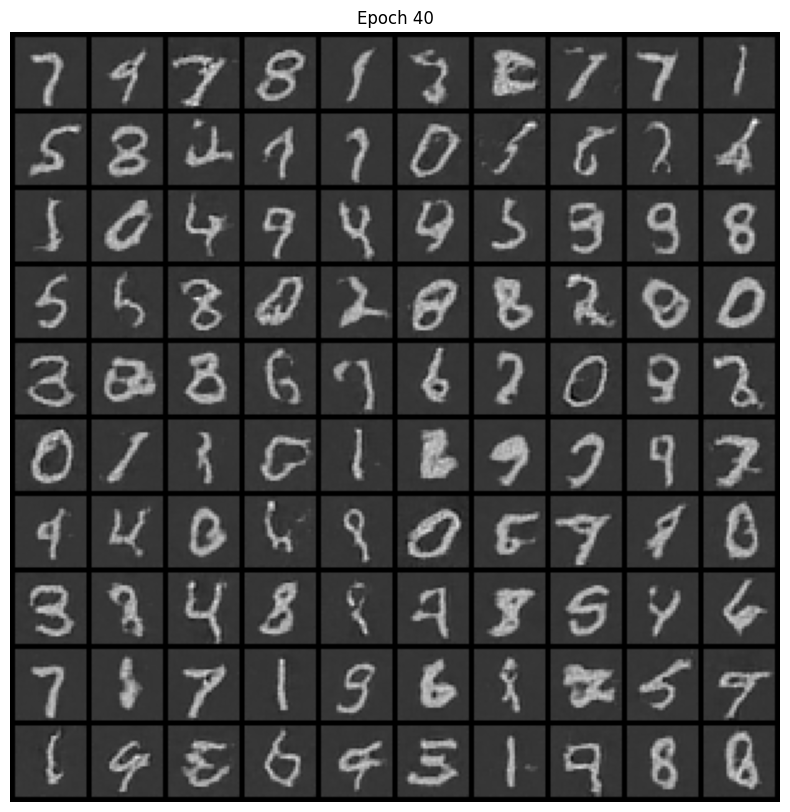

[Epoch 41/100] [Critic loss: -1.4118207693099976] [Generator loss: 11.246763229370117]
[Epoch 42/100] [Critic loss: -1.5033694505691528] [Generator loss: 11.408653259277344]
[Epoch 43/100] [Critic loss: -1.197348713874817] [Generator loss: 9.653148651123047]
[Epoch 44/100] [Critic loss: -1.2171827554702759] [Generator loss: 12.868990898132324]
[Epoch 45/100] [Critic loss: -1.3361625671386719] [Generator loss: 9.53349494934082]
[Epoch 46/100] [Critic loss: -1.1702948808670044] [Generator loss: 12.048978805541992]
[Epoch 47/100] [Critic loss: -1.2953001260757446] [Generator loss: 11.175878524780273]
[Epoch 48/100] [Critic loss: -1.0649882555007935] [Generator loss: 11.1176176071167]
[Epoch 49/100] [Critic loss: -1.2917273044586182] [Generator loss: 11.573294639587402]
[Epoch 50/100] [Critic loss: -1.2116458415985107] [Generator loss: 10.970980644226074]


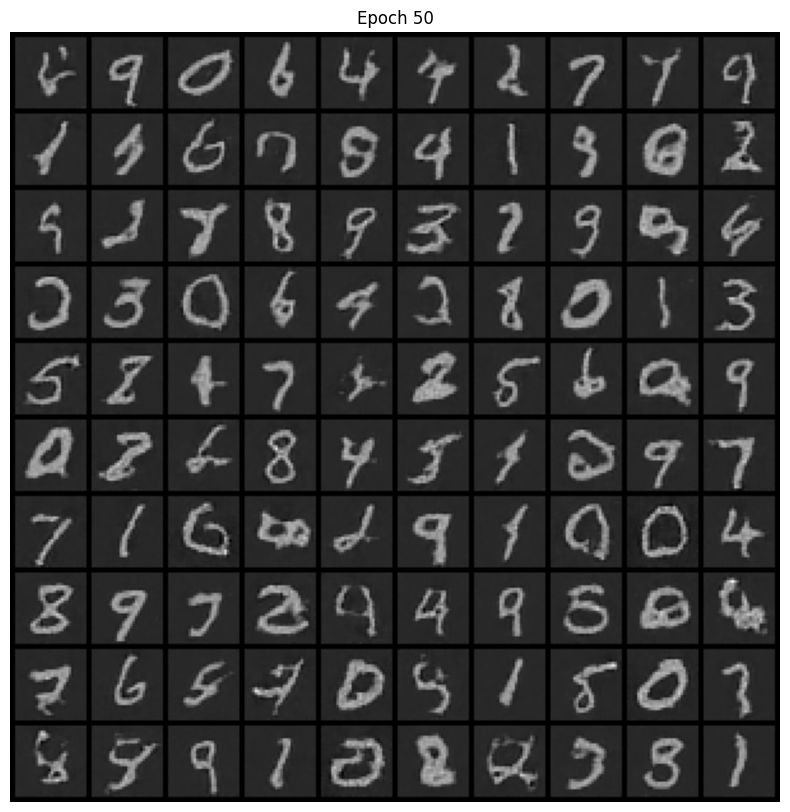

[Epoch 51/100] [Critic loss: -1.2064882516860962] [Generator loss: 10.805999755859375]
[Epoch 52/100] [Critic loss: -1.0725457668304443] [Generator loss: 10.354145050048828]
[Epoch 53/100] [Critic loss: -1.124985694885254] [Generator loss: 11.407464981079102]
[Epoch 54/100] [Critic loss: -1.1404392719268799] [Generator loss: 11.960482597351074]
[Epoch 55/100] [Critic loss: -1.3208880424499512] [Generator loss: 10.892431259155273]
[Epoch 56/100] [Critic loss: -1.240720272064209] [Generator loss: 11.85450267791748]
[Epoch 57/100] [Critic loss: -1.3151400089263916] [Generator loss: 11.932754516601562]
[Epoch 58/100] [Critic loss: -1.1177674531936646] [Generator loss: 10.159140586853027]
[Epoch 59/100] [Critic loss: -1.1986377239227295] [Generator loss: 10.91116714477539]
[Epoch 60/100] [Critic loss: -1.0339632034301758] [Generator loss: 11.163333892822266]


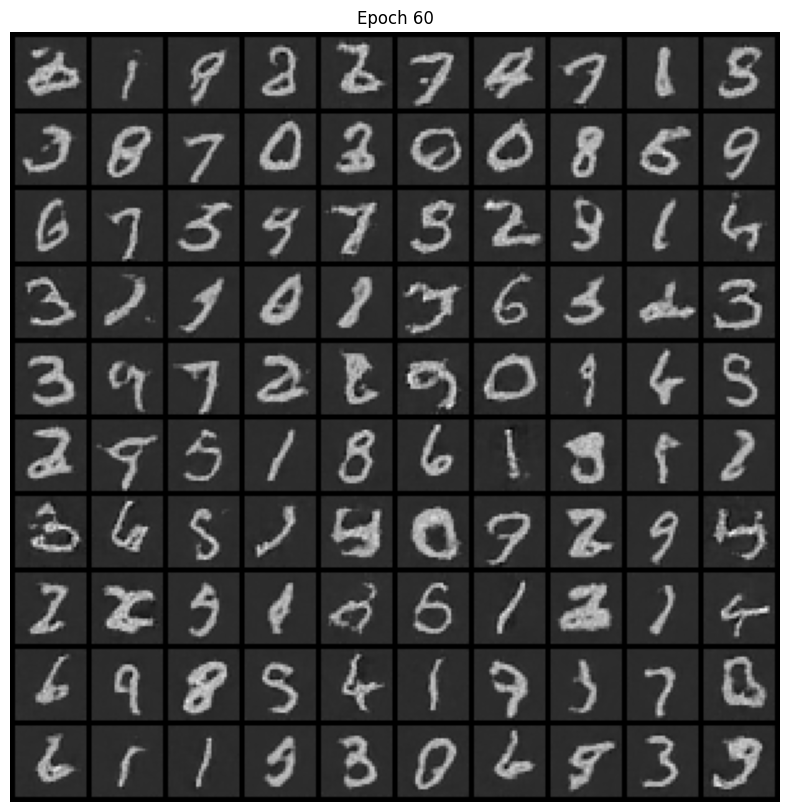

[Epoch 61/100] [Critic loss: -1.305040717124939] [Generator loss: 10.090402603149414]
[Epoch 62/100] [Critic loss: -1.149109125137329] [Generator loss: 12.181368827819824]
[Epoch 63/100] [Critic loss: -1.127196192741394] [Generator loss: 10.365473747253418]
[Epoch 64/100] [Critic loss: -1.2629157304763794] [Generator loss: 10.463027000427246]
[Epoch 65/100] [Critic loss: -1.1296526193618774] [Generator loss: 11.553258895874023]
[Epoch 66/100] [Critic loss: -1.240865707397461] [Generator loss: 10.721893310546875]
[Epoch 67/100] [Critic loss: -0.9871524572372437] [Generator loss: 8.867091178894043]
[Epoch 68/100] [Critic loss: -1.2057738304138184] [Generator loss: 9.53312873840332]
[Epoch 69/100] [Critic loss: -1.2854626178741455] [Generator loss: 8.572149276733398]
[Epoch 70/100] [Critic loss: -0.9816343784332275] [Generator loss: 9.421932220458984]


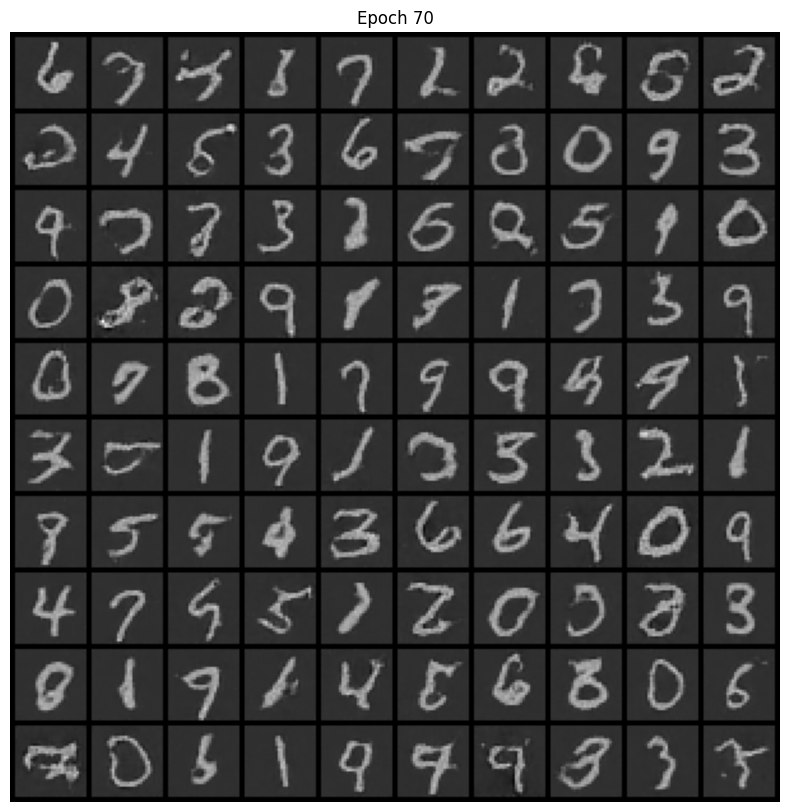

[Epoch 71/100] [Critic loss: -1.0778125524520874] [Generator loss: 10.756486892700195]
[Epoch 72/100] [Critic loss: -1.0418312549591064] [Generator loss: 8.842504501342773]
[Epoch 73/100] [Critic loss: -1.1181695461273193] [Generator loss: 9.500567436218262]
[Epoch 74/100] [Critic loss: -0.8873977065086365] [Generator loss: 10.944324493408203]
[Epoch 75/100] [Critic loss: -1.3242181539535522] [Generator loss: 10.432246208190918]
[Epoch 76/100] [Critic loss: -1.1371815204620361] [Generator loss: 9.632024765014648]
[Epoch 77/100] [Critic loss: -1.3032505512237549] [Generator loss: 11.058235168457031]
[Epoch 78/100] [Critic loss: -0.9233322143554688] [Generator loss: 9.629217147827148]
[Epoch 79/100] [Critic loss: -1.0994257926940918] [Generator loss: 9.418325424194336]
[Epoch 80/100] [Critic loss: -1.1212369203567505] [Generator loss: 10.822500228881836]


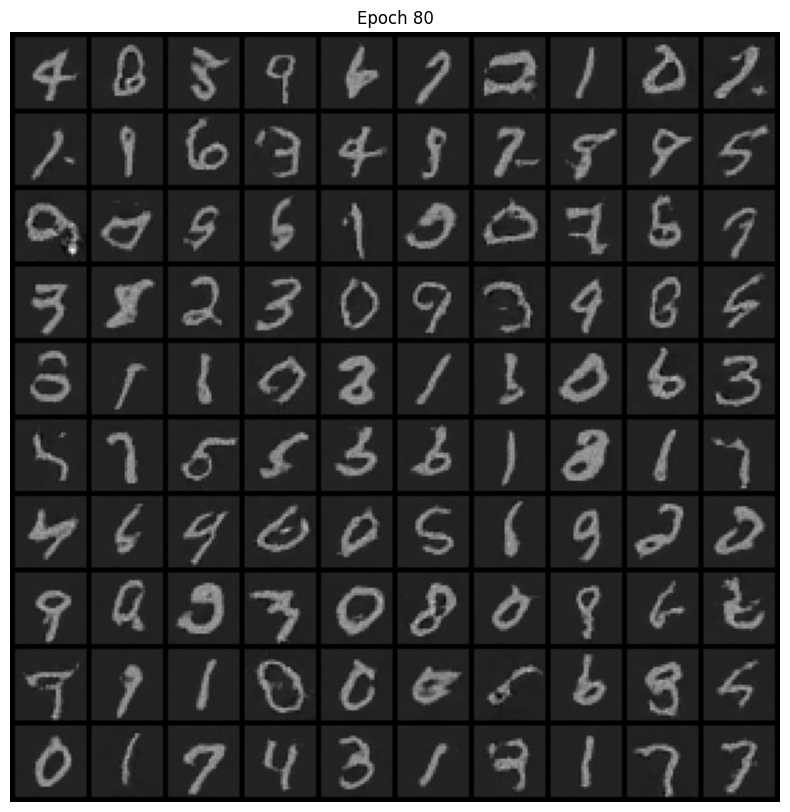

[Epoch 81/100] [Critic loss: -0.9682931900024414] [Generator loss: 10.272279739379883]
[Epoch 82/100] [Critic loss: -1.1066495180130005] [Generator loss: 9.46082878112793]
[Epoch 83/100] [Critic loss: -1.1219239234924316] [Generator loss: 11.045234680175781]
[Epoch 84/100] [Critic loss: -1.0660712718963623] [Generator loss: 10.487735748291016]
[Epoch 85/100] [Critic loss: -1.1816604137420654] [Generator loss: 10.7760009765625]
[Epoch 86/100] [Critic loss: -1.052473545074463] [Generator loss: 10.282320022583008]
[Epoch 87/100] [Critic loss: -1.0119025707244873] [Generator loss: 9.583025932312012]
[Epoch 88/100] [Critic loss: -0.9949101209640503] [Generator loss: 9.449956893920898]
[Epoch 89/100] [Critic loss: -0.9606335759162903] [Generator loss: 10.216182708740234]
[Epoch 90/100] [Critic loss: -0.8857184648513794] [Generator loss: 9.599142074584961]


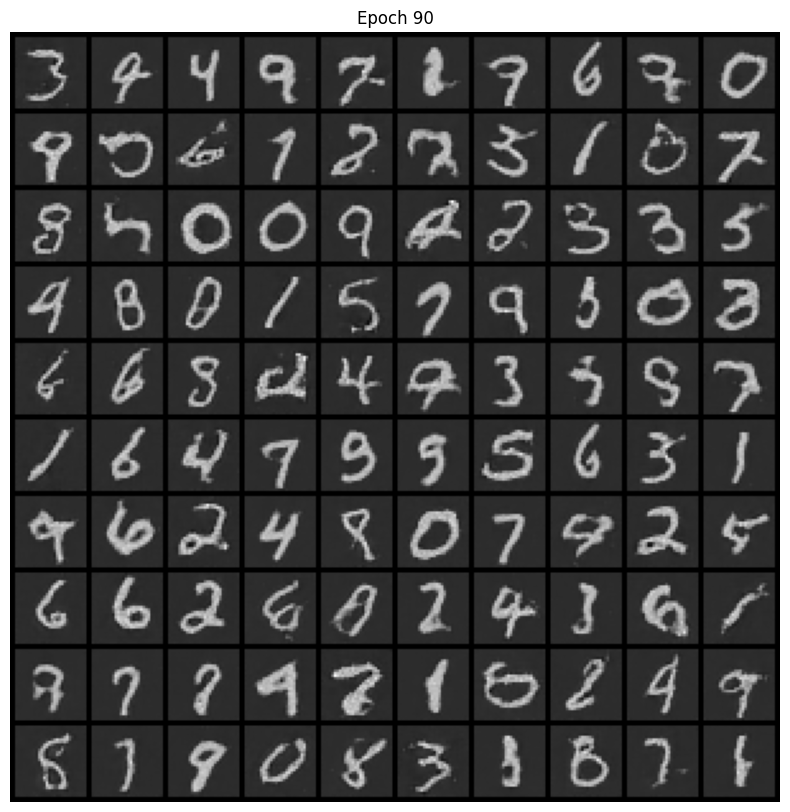

[Epoch 91/100] [Critic loss: -0.9820547103881836] [Generator loss: 10.634822845458984]
[Epoch 92/100] [Critic loss: -1.009731411933899] [Generator loss: 8.940042495727539]
[Epoch 93/100] [Critic loss: -1.0752835273742676] [Generator loss: 9.450878143310547]
[Epoch 94/100] [Critic loss: -0.945328950881958] [Generator loss: 9.088554382324219]
[Epoch 95/100] [Critic loss: -0.9354373216629028] [Generator loss: 10.582789421081543]
[Epoch 96/100] [Critic loss: -1.1214157342910767] [Generator loss: 9.315107345581055]
[Epoch 97/100] [Critic loss: -1.0469294786453247] [Generator loss: 9.407905578613281]
[Epoch 98/100] [Critic loss: -1.0289994478225708] [Generator loss: 9.597419738769531]
[Epoch 99/100] [Critic loss: -0.8814538717269897] [Generator loss: 8.384237289428711]
[Epoch 100/100] [Critic loss: -0.9103058576583862] [Generator loss: 9.649458885192871]


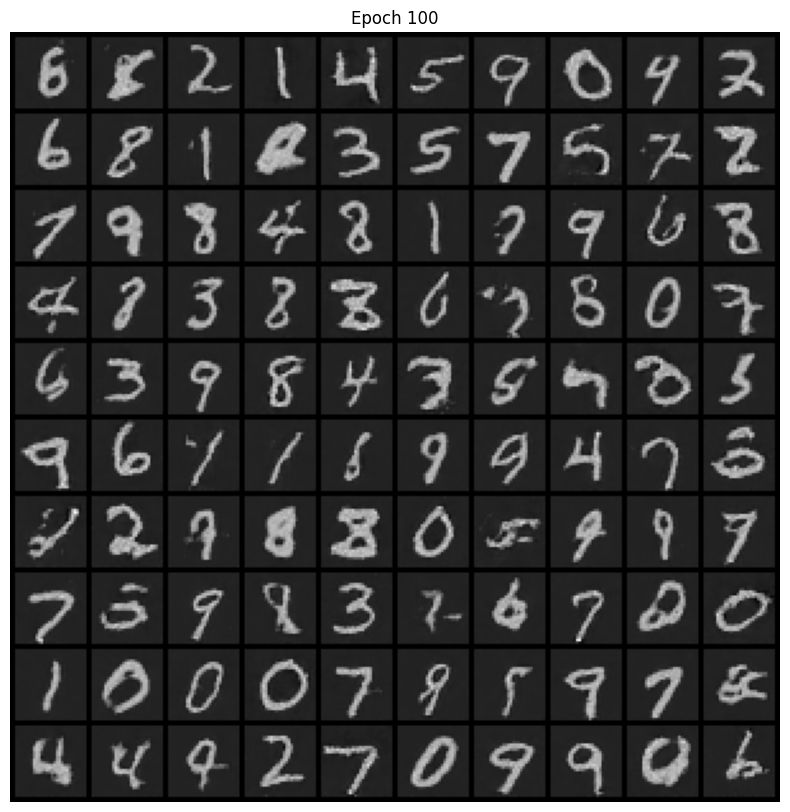

In [14]:
num_epochs=100
n_critic = 5

generator_loss_list = []
critic_loss_list = []

for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(train_loader):
        real_images = imgs.to(device)
        # Sample noise as a generator input
        z = torch.randn(len(real_images), 64).to(device)

        # Generate a batch of images
        fake_images = generator(z)

        # ---------------------
        #  Train Critic
        # ---------------------
        optimizer_C.zero_grad()

        # Compute critic loss and gradient penalty
        critic_loss = -(torch.mean(critic(real_images)) - torch.mean(critic(fake_images)))
        gp = gradient_penalty(critic, real_images, fake_images, device=device)
        critic_loss = critic_loss + gp

        # Backward and optimize
        critic_loss.backward()
        optimizer_C.step()

        # ---------------------
        #  Train Generator
        # ---------------------
        optimizer_G.zero_grad()

        # If you train the critic multiple times within one generator update step
        # make sure to generate new fake images for the generator update
        fake_images = generator(z)
        gen_loss = -torch.mean(critic(fake_images))

        # Backward and optimize
        gen_loss.backward()
        optimizer_G.step()

    generator_loss_list.append(gen_loss.item())
    critic_loss_list.append(critic_loss.item())
    print(f"\r[Epoch {epoch+1}/{num_epochs}] [Critic loss: {critic_loss.item()}] [Generator loss: {gen_loss.item()}]")
    # Generate and save images at the start, mid, and end of training
    if (epoch+1) % 10 == 0 or epoch == 0:
        save_generated_images(epoch, generator, torch.randn(100, 64).to(device))

### Plot Losses

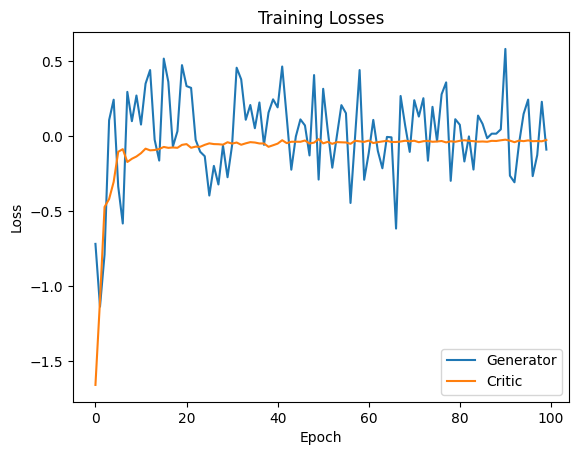

In [ ]:
plot_loss(generator_loss_list, critic_loss_list)

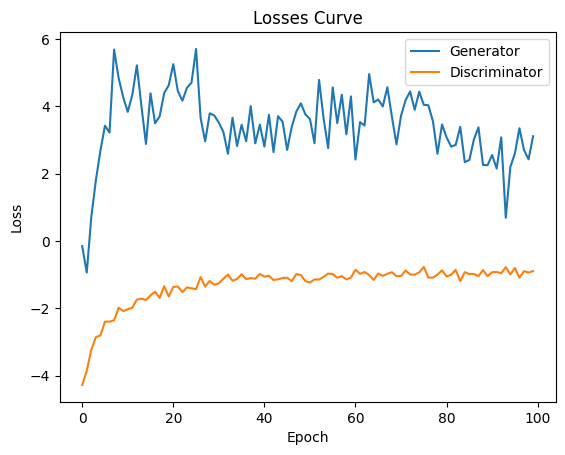

In [ ]:
plot_loss(generator_loss_list, critic_loss_list)

### Save/Load model

In [ ]:
# Save the Generator
torch.save(generator.state_dict(), './wgan_generator_state.pth')

# Save the Discriminator
torch.save(critic.state_dict(), './wgan_critic_state.pth')

In [ ]:
generator = Generator()

generator.load_state_dict(torch.load('wgan_generator_state.pth', map_location=torch.device(device)))

### FID

In [16]:
fid_value = calculate_fid(generator, batch_size=batch_size, device=device)
print(f'FID score: {fid_value}') # lr = 0.0001

  2%|▏         | 3/128 [00:06<04:26,  2.13s/it]


FID score: 45.833160400390625


In [ ]:
fid_value = calculate_fid(generator, batch_size=batch_size)
print(f'FID score: {fid_value}') # lr = 0.00005

  2%|▏         | 3/128 [05:33<3:51:37, 111.18s/it]


FID score: 40.729583740234375


## Q2.3: Self-Supervised GAN

* Generator

In [21]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.block1 = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        )
        self.block2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest')
        )

    def forward(self, x):
        identity = self.block2(x)
        out = self.block1(x)
        out += identity
        return out

In [22]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.initial_linear = nn.Sequential(
            nn.Linear(128, 256 * 4 * 4),
            nn.BatchNorm1d(256 * 4 * 4),
        )
        self.res_blocks = nn.Sequential(
            ResidualBlock(256, 256),
            ResidualBlock(256, 256),
            ResidualBlock(256, 256)
        )
        self.final_layers = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 1, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, x):
        x = self.initial_linear(x)
        x = x.view(-1, 256, 4, 4)  # Reshape to match the spatial dimensions
        x = self.res_blocks(x)
        x = self.final_layers(x)
        return x

In [ ]:
summary(Generator().to(device),(128,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 4096]         528,384
       BatchNorm1d-2                 [-1, 4096]           8,192
          Upsample-3            [-1, 256, 8, 8]               0
       BatchNorm2d-4            [-1, 256, 4, 4]             512
              ReLU-5            [-1, 256, 4, 4]               0
          Upsample-6            [-1, 256, 8, 8]               0
            Conv2d-7            [-1, 256, 8, 8]         590,080
       BatchNorm2d-8            [-1, 256, 8, 8]             512
              ReLU-9            [-1, 256, 8, 8]               0
           Conv2d-10            [-1, 256, 8, 8]         590,080
    ResidualBlock-11            [-1, 256, 8, 8]               0
         Upsample-12          [-1, 256, 16, 16]               0
      BatchNorm2d-13            [-1, 256, 8, 8]             512
             ReLU-14            [-1, 25

* Discriminator

In [23]:
class DiscriminatorResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, first_block=False):
        super(DiscriminatorResidualBlock, self).__init__()
        self.first_block = first_block

        self.first_relu = nn.ReLU(inplace=True)

        self.block1 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, 3, 1, 1)),
            nn.ReLU(inplace=True),
            nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels, 3, 1, 1)),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=1)
        )

        self.block2 = nn.Sequential(
            nn.AvgPool2d(kernel_size=2, stride=2, padding=1),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        )

    def forward(self, x):
        if self.first_block:
            x = self.first_relu(x)
        identity = self.block2(x)
        out = self.block1(x)
        out += identity
        return out

In [24]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.res_blocks = nn.Sequential(
            DiscriminatorResidualBlock(1, 128, first_block=True),
            DiscriminatorResidualBlock(128, 128),
            DiscriminatorResidualBlock(128, 128),
            DiscriminatorResidualBlock(128, 128),
            nn.ReLU(inplace=True)
        )
        self.linear_discriminate = nn.Linear(128*3*3, 1)
        self.linear_rotation = nn.Linear(128*3*3, 4)

    def forward(self, x):
        x = self.res_blocks(x)
        x = x.view(x.size(0), -1)  # Flatten the features
        real_fake_output = self.linear_discriminate(x)
        rotation_output = self.linear_rotation(x)
        return real_fake_output, rotation_output


In [ ]:
summary(Discriminator().to(device),(1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
              ReLU-1            [-1, 1, 32, 32]               0
         AvgPool2d-2            [-1, 1, 17, 17]               0
            Conv2d-3          [-1, 128, 17, 17]             256
            Conv2d-4          [-1, 128, 32, 32]           1,280
              ReLU-5          [-1, 128, 32, 32]               0
            Conv2d-6          [-1, 128, 32, 32]         147,584
         AvgPool2d-7          [-1, 128, 17, 17]               0
DiscriminatorResidualBlock-8          [-1, 128, 17, 17]               0
         AvgPool2d-9            [-1, 128, 9, 9]               0
           Conv2d-10            [-1, 128, 9, 9]          16,512
           Conv2d-11          [-1, 128, 17, 17]         147,584
             ReLU-12          [-1, 128, 17, 17]               0
           Conv2d-13          [-1, 128, 17, 17]         147,584
        AvgPool2d-14           

### Load data

In [18]:
# Define a custom dataset
class RotatedMNIST(torch.utils.data.Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset
        # self.rotations = [0.0, 90.0, 180.0, 270.0]
        self.rotations = [0.0]

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        image, label = self.mnist_dataset[idx]
        # Randomly choose a rotation angle
        rotation = np.random.choice(self.rotations)
        # Rotate the image
        rotated_image = transforms.functional.rotate(image, rotation)
        # Create a rotation label
        rotation_label = self.rotations.index(rotation)
        return rotated_image, label, rotation_label

In [19]:
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

indices = np.random.choice(len(train_dataset), 16000, replace=False)
reduced_dataset = torch.utils.data.Subset(train_dataset, indices)

rotated_mnist_dataset = RotatedMNIST(reduced_dataset)

train_loader = DataLoader(rotated_mnist_dataset, batch_size=64, shuffle=True)

In [20]:
print('first len:',len(train_dataset))
print('subset len:',len(train_loader.dataset))

first len: 60000
subset len: 16000


### Initialize

In [ ]:
# del generator, discriminator
torch.cuda.empty_cache()

In [25]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [26]:
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [27]:
def gan_loss(real_output, fake_output):
    real_loss = F.binary_cross_entropy_with_logits(real_output, torch.ones_like(real_output))
    fake_loss = F.binary_cross_entropy_with_logits(fake_output, torch.zeros_like(fake_output))
    total_loss = real_loss + fake_loss
    return total_loss

def rotation_loss(rotation_output, labels):
    # Assuming labels are given as the index of the rotation: {0: 0, 90: 1, 180: 2, 270: 3}
    rotation_loss = F.cross_entropy(rotation_output, labels)
    return rotation_loss

### Trainig loop

[Epoch 1/50] [D loss: -240870.484375] [G loss: 338371.0625]


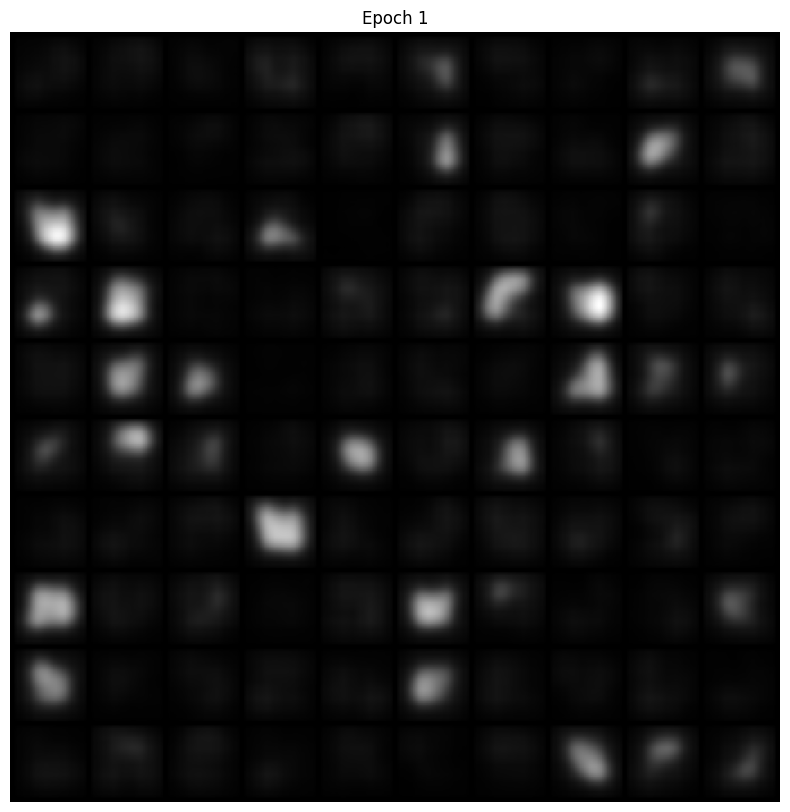

[Epoch 2/50] [D loss: 735.928955078125] [G loss: 2559.346435546875]
[Epoch 3/50] [D loss: 528.24267578125] [G loss: 2207.1953125]
[Epoch 4/50] [D loss: 387.646240234375] [G loss: 1947.990478515625]
[Epoch 5/50] [D loss: 305.8043212890625] [G loss: 1776.796142578125]
[Epoch 6/50] [D loss: 210.8238525390625] [G loss: 1662.0562744140625]
[Epoch 7/50] [D loss: 152.8409423828125] [G loss: 1562.905029296875]
[Epoch 8/50] [D loss: 90.61767578125] [G loss: 1469.120849609375]
[Epoch 9/50] [D loss: 13.69482421875] [G loss: 1381.5947265625]
[Epoch 10/50] [D loss: -56.318359375] [G loss: 1336.3919677734375]


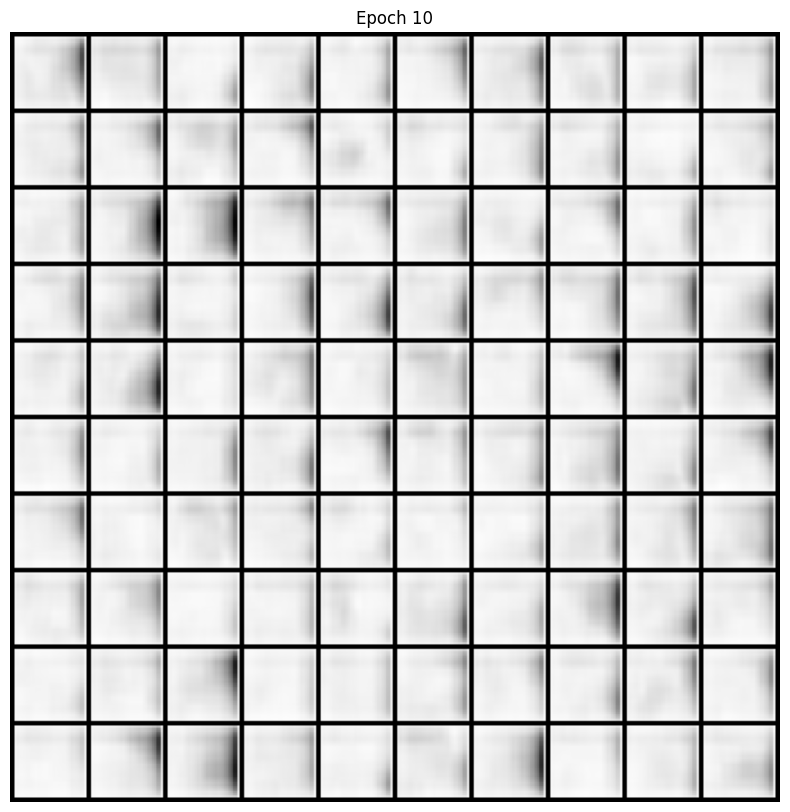

[Epoch 11/50] [D loss: -143.6732177734375] [G loss: 1419.477783203125]
[Epoch 12/50] [D loss: 51.8460693359375] [G loss: 1212.252685546875]
[Epoch 13/50] [D loss: 52.8603515625] [G loss: 1142.771240234375]
[Epoch 14/50] [D loss: 47.0330810546875] [G loss: 1076.8505859375]
[Epoch 15/50] [D loss: 42.91229248046875] [G loss: 1009.7228393554688]
[Epoch 16/50] [D loss: 41.0157470703125] [G loss: 942.775146484375]
[Epoch 17/50] [D loss: 36.774658203125] [G loss: 875.5020751953125]
[Epoch 18/50] [D loss: 33.2935791015625] [G loss: 809.9428100585938]
[Epoch 19/50] [D loss: 29.2305908203125] [G loss: 748.154541015625]
[Epoch 20/50] [D loss: 24.6734619140625] [G loss: 691.1063842773438]


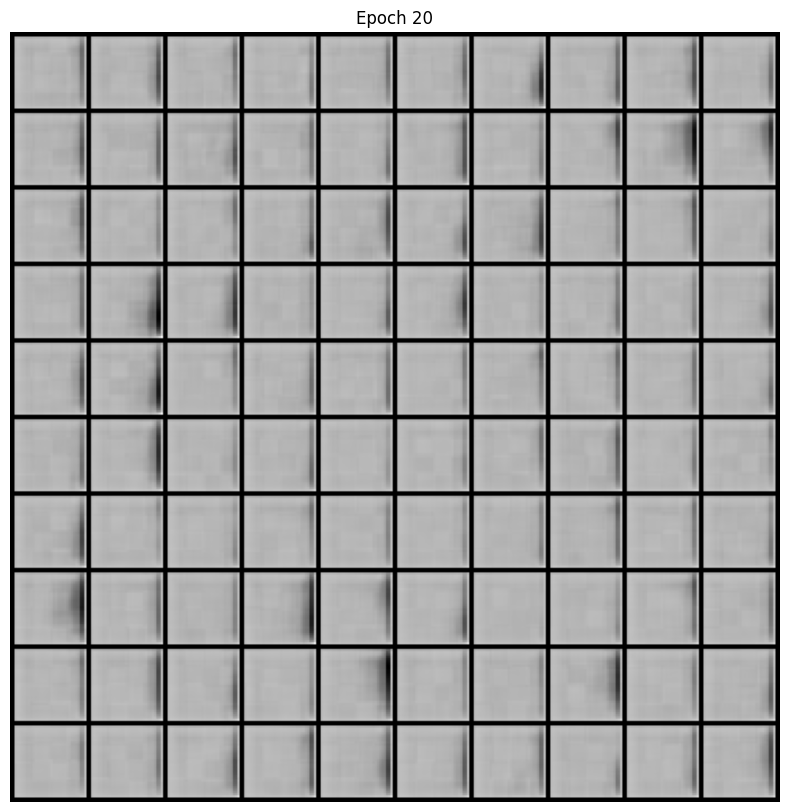

[Epoch 21/50] [D loss: 21.93414306640625] [G loss: 636.9168701171875]
[Epoch 22/50] [D loss: 18.92620849609375] [G loss: 587.5167846679688]
[Epoch 23/50] [D loss: 15.37542724609375] [G loss: 539.1925659179688]
[Epoch 24/50] [D loss: 14.181304931640625] [G loss: 490.9923095703125]
[Epoch 25/50] [D loss: 11.38885498046875] [G loss: 445.7237548828125]
[Epoch 26/50] [D loss: 8.787322998046875] [G loss: 399.0791015625]
[Epoch 27/50] [D loss: 7.307403564453125] [G loss: 358.8291015625]
[Epoch 28/50] [D loss: 5.807525634765625] [G loss: 321.05828857421875]
[Epoch 29/50] [D loss: 4.0341796875] [G loss: 275.13983154296875]
[Epoch 30/50] [D loss: 3.384002685546875] [G loss: 224.90249633789062]


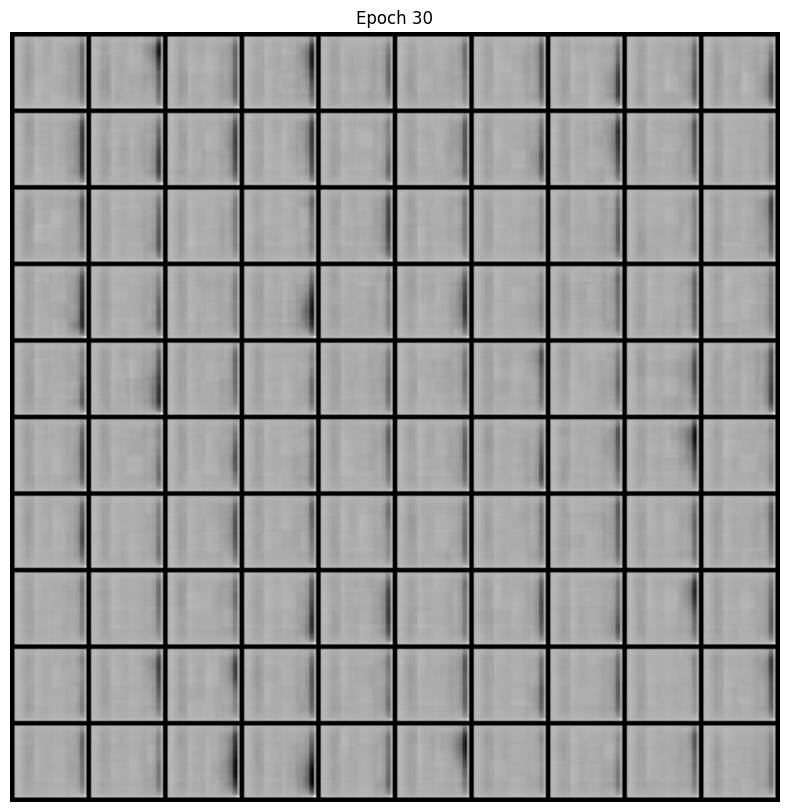

[Epoch 31/50] [D loss: 2.4583587646484375] [G loss: 180.3474884033203]
[Epoch 32/50] [D loss: 2.5073699951171875] [G loss: 144.3116455078125]
[Epoch 33/50] [D loss: 2.010955810546875] [G loss: 122.58710479736328]
[Epoch 34/50] [D loss: 1.5223236083984375] [G loss: 112.75666809082031]
[Epoch 35/50] [D loss: 1.3928756713867188] [G loss: 93.94784545898438]
[Epoch 36/50] [D loss: 0.872894287109375] [G loss: 71.63931274414062]
[Epoch 37/50] [D loss: 0.7677268981933594] [G loss: 57.19646072387695]
[Epoch 38/50] [D loss: -9.585205078125] [G loss: -141.818115234375]
[Epoch 39/50] [D loss: -1547.76513671875] [G loss: 4915.43994140625]
[Epoch 40/50] [D loss: -405260.25] [G loss: 1380347.0]


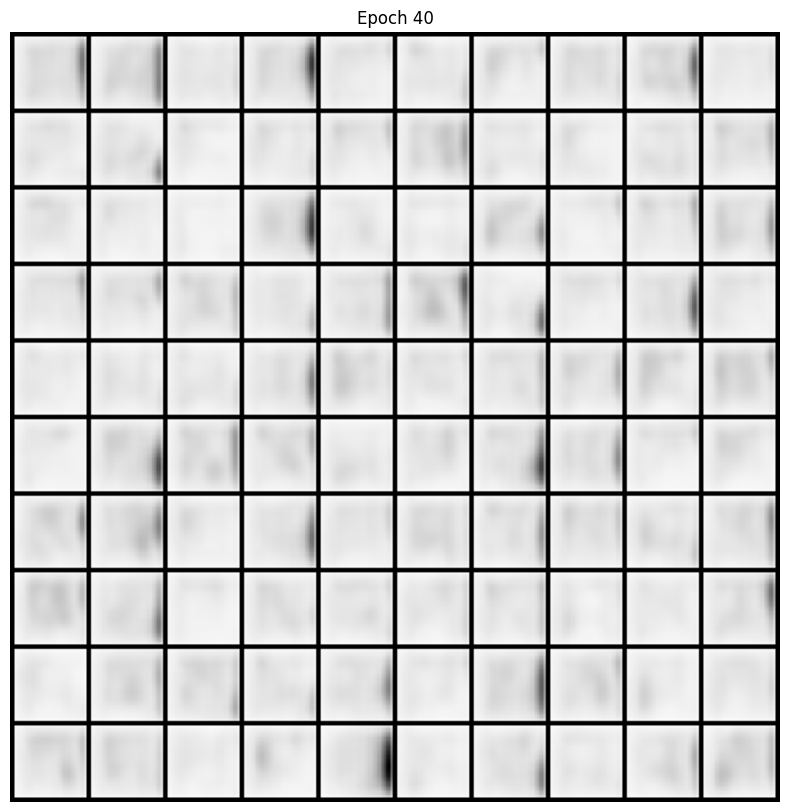

[Epoch 41/50] [D loss: -2964762.5] [G loss: 10267445.0]
[Epoch 42/50] [D loss: -9442956.0] [G loss: 35612376.0]
[Epoch 43/50] [D loss: -23429096.0] [G loss: 86323552.0]
[Epoch 44/50] [D loss: -47358240.0] [G loss: 176800896.0]
[Epoch 45/50] [D loss: -72156032.0] [G loss: 305284672.0]
[Epoch 46/50] [D loss: -127952992.0] [G loss: 512791488.0]
[Epoch 47/50] [D loss: -185492352.0] [G loss: 760239616.0]
[Epoch 48/50] [D loss: -300007488.0] [G loss: 1127089408.0]
[Epoch 49/50] [D loss: -407652096.0] [G loss: 1597034752.0]
[Epoch 50/50] [D loss: -544457472.0] [G loss: 2194342656.0]


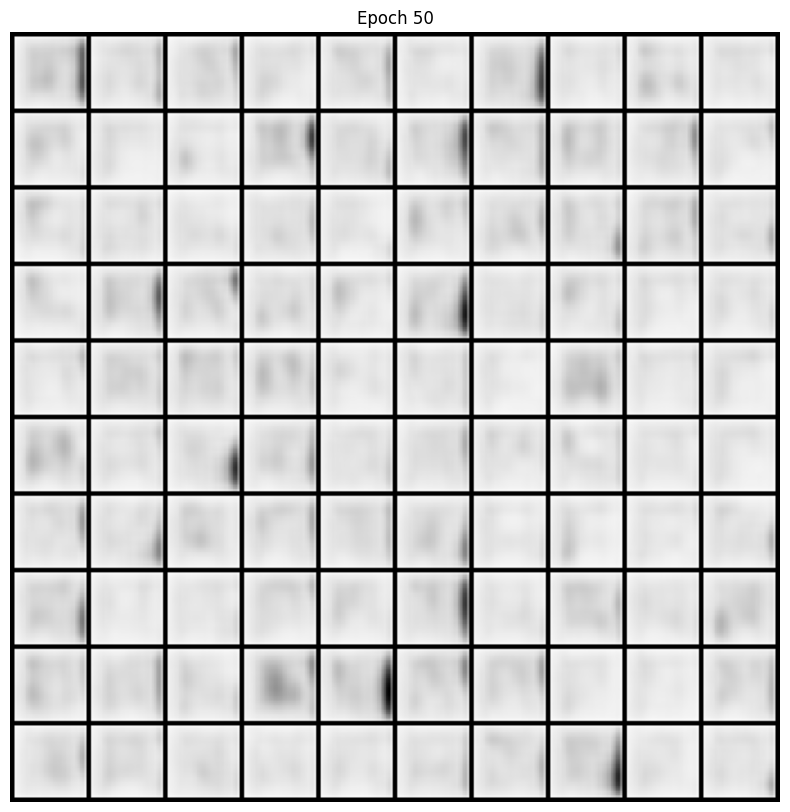

In [28]:
num_epochs = 50

G_loss_list = []
D_loss_list = []

alpha = 0.2  # Weight for the rotation loss in the discriminator loss
beta = 0.5  # Weight for the rotation loss in the generator loss

for epoch in range(num_epochs):
    for i, (imgs, labels, rotation_labels) in enumerate(train_loader):
        real_images = imgs.to(device)
        rotation_labels = rotation_labels.to(device)

        # Sample noise
        z = torch.randn(len(real_images), 128).to(device)

        # Generate a fake images
        fake_images = generator(z)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        real_output, rotation_output = discriminator(real_images)
        fake_output, _ = discriminator(fake_images.detach())

        D_loss = -(torch.mean(real_output) - torch.mean(fake_output))
        D_rotation_loss = rotation_loss(rotation_output, rotation_labels)
        D_loss_total = D_loss + alpha * D_rotation_loss

        D_loss_total.backward()
        optimizer_D.step()

        # ---------------------
        #  Train Generator
        # ---------------------
        optimizer_G.zero_grad()

        fake_output, fake_rotation_output = discriminator(fake_images)

        G_loss = -torch.mean(fake_output)
        G_rotation_loss = rotation_loss(fake_rotation_output, rotation_labels)
        G_loss_total = G_loss - beta * G_rotation_loss

        G_loss_total.backward()
        optimizer_G.step()

        if i%10==0:
            # Save losses
            G_loss_list.append(G_loss_total.item())
            D_loss_list.append(D_loss_total.item())

    print(f"[Epoch {epoch+1}/{num_epochs}] [D loss: {D_loss_total.item()}] [G loss: {G_loss_total.item()}]")

    # Generate and save images at the start, mid, and end of training
    if (epoch+1) % 10 == 0 or epoch == 0:
        save_generated_images(epoch, generator, torch.randn(100, 128).to(device))

In [ ]:
def create_rotated_images(real_images, device):
    # Assuming real_images is a batch of images of shape (batch_size, channels, height, width)
    # Define the rotation angles
    rotations = [0, 90, 180, 270]
    # Create a tensor to hold the rotated images
    rotated_images = torch.zeros_like(real_images, device=device)
    # Tensor to hold the labels for the rotations
    rotation_labels = torch.LongTensor(real_images.size(0))

    for i, image in enumerate(real_images):
        # Randomly choose a rotation
        rotation = np.random.choice(rotations)
        # Rotate the image
        rotated_image = torch.rot90(image, rotations.index(rotation), [1, 2])
        # Add the rotated image and its label to the tensors
        rotated_images[i] = rotated_image
        rotation_labels[i] = rotations.index(rotation)

    return rotated_images, rotation_labels.to(device)

In [ ]:
z_dim = 128
alpha = 0.2
beta = 0.5
save_interval = 10
n_critic = 2

G_loss_list, D_loss_list = [], []

for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(train_loader):
        real_images = imgs.to(device)

        # Generate a batch of fake images
        z = torch.randn(len(real_images), z_dim, device=device)
        fake_images = generator(z)

        # Get the outputs from the discriminator for both real and fake images
        real_output, _ = discriminator(real_images)
        fake_output, _ = discriminator(fake_images.detach())

        # Discriminator real/fake loss
        D_gan_loss = gan_loss(real_output, fake_output)

        # Prepare rotated images and labels for self-supervised rotation loss
        rotated_images, rotation_labels = create_rotated_images(real_images, device)  # Implement this function
        _, rotation_output = discriminator(rotated_images)
        D_rotation_loss = rotation_loss(rotation_output, rotation_labels)

        # Backpropagation for the discriminator
        D_loss = D_gan_loss + beta * D_rotation_loss
        optimizer_D.zero_grad()
        D_loss.backward()
        optimizer_D.step()

        # Train the generator every n_critic steps (n_critic is typically 1 for standard GAN training)
        if i % n_critic == 0:
            # Generate a batch of fake images for generator update
            z = torch.randn(batch_size, z_dim, device=device)
            fake_images = generator(z)

            # Get the discriminator's evaluation of the new fake images
            fake_output, rotation_output = discriminator(fake_images)
            G_loss = -torch.mean(fake_output)

            # Backpropagation for the generator
            optimizer_G.zero_grad()
            G_loss.backward()
            optimizer_G.step()

        if i % 25 == 0:
            G_loss_list.append(G_loss.item())
            D_loss_list.append(D_loss.item())

    print(f"[Epoch {epoch+1}/{num_epochs}] [D loss: {D_loss.item()}] [G loss: {G_loss.item()}]")

    # Generate and save images at the start, mid, and end of training
    if (epoch+1) % save_interval == 0 or epoch == 0:
        save_generated_images(epoch, generator, torch.randn(100, 128).to(device))
        # torch.save(generator.state_dict(), f'generator_epoch_{epoch+1}.pth')
        # torch.save(discriminator.state_dict(), f'discriminator_epoch_{epoch+1}.pth')

In [29]:
# Save the Generator
torch.save(generator.state_dict(), './ssgan_generator_state.pth')

# Save the Discriminator
torch.save(discriminator.state_dict(), './ssgan_discriminator_state.pth')